1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

file_name = "data_000637.txt"
data = pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
N = 50000

if N >= 10000 and N <= data.shape[0]:
    subdata = data[0:N].copy()
else:
    print("N is not correct") 

2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
BX_max = subdata['BX_COUNTER'].max()
print("The maximum value of the BX counter in the selected part of the DataFrame is: ", BX_max)

The maximum value of the BX counter in the selected part of the DataFrame is:  3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
meas_start = subdata.loc[0, 'TDC_MEAS']
bx_start = subdata.loc[0, 'BX_COUNTER'] 
orbit_start = subdata.loc[0, 'ORBIT_CNT']

subdata['ABS_TIME'] = (subdata['ORBIT_CNT']-orbit_start)*BX_max*25  + (subdata['BX_COUNTER']-bx_start)*25 + (subdata['TDC_MEAS']-meas_start)*(25/30)

print("The total time relative to", N, "rows is: ", pd.to_timedelta(subdata.loc[N-1, 'ABS_TIME']))
subdata

The total time relative to 50000 rows is:  0 days 00:00:00.044240658


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
49995,1,1,2,3869200664,1103,4,4.423848e+07
49996,1,1,4,3869200664,1105,14,4.423854e+07
49997,1,0,59,3869200664,1191,17,4.424069e+07
49998,1,0,32,3869200664,1191,1,4.424068e+07


In [5]:
# Conversion of the new column to a time series
 
time_intervals = pd.to_datetime(subdata['ABS_TIME'])
time_intervals

0       1970-01-01 00:00:00.000000000
1       1970-01-01 00:00:00.000000000
2       1970-01-01 00:00:00.000004476
3       1970-01-01 00:00:00.000004594
4       1970-01-01 00:00:00.000009649
                     ...             
49995   1970-01-01 00:00:00.044238481
49996   1970-01-01 00:00:00.044238540
49997   1970-01-01 00:00:00.044240692
49998   1970-01-01 00:00:00.044240679
49999   1970-01-01 00:00:00.044240658
Name: ABS_TIME, Length: 50000, dtype: datetime64[ns]

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
lenght = data.shape[0]
BX_max_tot = data['BX_COUNTER'].max()

data['ABS_TIME'] = (data['ORBIT_CNT']-orbit_start)*BX_max_tot*25  + (data['BX_COUNTER']-bx_start)*25 + (data['TDC_MEAS']-meas_start)*(25/30)

print("The total time in nanoseconds is: ", data.loc[lenght-1, 'ABS_TIME'])

tot_time = pd.to_timedelta(data.loc[lenght-1, 'ABS_TIME'])
print("The total time in hours is: ", tot_time)
data

The total time in nanoseconds is:  980140993.3333334
The total time in hours is:  0 days 00:00:00.980140993


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.801410e+08
1310716,1,1,4,3869211171,763,11,9.801410e+08
1310717,1,0,64,3869211171,764,0,9.801410e+08
1310718,1,0,139,3869211171,769,0,9.801412e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
subdata['CHANNEL_COUNTS'] = 1

df = pd.DataFrame({ 'COUNTS' : subdata.groupby('TDC_CHANNEL')['CHANNEL_COUNTS'].sum()})
subdata = subdata.drop(['CHANNEL_COUNTS'], axis=1)
noisy_channels = df.sort_values(by=['COUNTS'], ascending=False)[0:3]

print("The three channels with more counts are: \n")

noisy_channels

The three channels with more counts are: 



,COUNTS
TDC_CHANNEL,
139,4175
64,2523
63,2472


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [8]:
full_orbits = subdata.loc[:, 'ORBIT_CNT'].drop_duplicates()
print("The number of non empty orbits is", len(full_orbits), "and they are: \n", np.array(full_orbits.values))


The number of non empty orbits is 498 and they are: 
 [3869200167 3869200168 3869200169 3869200170 3869200171 3869200172
 3869200173 3869200174 3869200175 3869200176 3869200177 3869200178
 3869200179 3869200180 3869200181 3869200182 3869200183 3869200184
 3869200185 3869200186 3869200187 3869200188 3869200189 3869200190
 3869200191 3869200192 3869200193 3869200194 3869200195 3869200196
 3869200197 3869200198 3869200199 3869200200 3869200201 3869200202
 3869200203 3869200204 3869200205 3869200206 3869200207 3869200208
 3869200209 3869200210 3869200211 3869200212 3869200213 3869200214
 3869200215 3869200216 3869200217 3869200218 3869200219 3869200220
 3869200221 3869200222 3869200223 3869200224 3869200225 3869200226
 3869200227 3869200228 3869200229 3869200230 3869200231 3869200232
 3869200233 3869200234 3869200235 3869200236 3869200237 3869200238
 3869200239 3869200240 3869200241 3869200242 3869200243 3869200244
 3869200245 3869200246 3869200247 3869200248 3869200249 3869200250
 3869200

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
channel_139_indices = list(subdata.query('TDC_CHANNEL == 139').index.to_numpy()) # I find the indices of all channels 139
#orbit_139 = subdata.loc[channel_139_indices, 'ORBIT_CNT'].drop_duplicates() # In this way I would create a series
orbit_139 = pd.DataFrame({ 'ORBIT_CNT_139' : subdata.loc[channel_139_indices, 'ORBIT_CNT'].drop_duplicates() }) # In this way I create a DataFrame
print("The orbits with at least one count in channel 139 are: \n") # This returns a DataFrame
#print(orbit_139.values)  # This returns a list of orbits centers

orbit_139

The orbits with at least one count in channel 139 are: 



,ORBIT_CNT_139
7,3869200167
48,3869200168
136,3869200169
257,3869200170
359,3869200171
...,...
49539,3869200660
49670,3869200661
49793,3869200662
49868,3869200663


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
fpga0 = subdata.query('FPGA == 0').copy()
fpga0['CHANNEL_COUNTS'] = 1 
print("Counts in FPGA 0: \n")
print(fpga0.groupby('TDC_CHANNEL')['CHANNEL_COUNTS'].sum())

fpga1 = subdata.query('FPGA == 1').copy()
fpga1['CHANNEL_COUNTS'] = 1
print("Counts in FPGA 1: \n")
print(fpga1.groupby('TDC_CHANNEL')['CHANNEL_COUNTS'].sum())

Counts in FPGA 0: 

TDC_CHANNEL
1        40
2        56
3        57
4        72
5        59
       ... 
121     287
122     274
123     716
124     682
139    2915
Name: CHANNEL_COUNTS, Length: 118, dtype: int64
Counts in FPGA 1: 

TDC_CHANNEL
1      1078
2      1218
3       854
4       993
5       586
       ... 
126      24
127      47
128      52
130       1
139    1260
Name: CHANNEL_COUNTS, Length: 129, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Counts per channel')

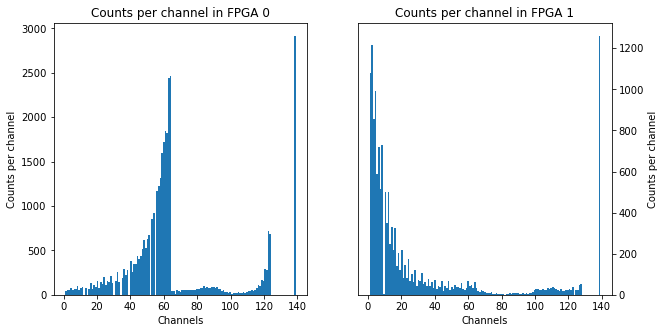

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.hist(fpga0.loc[:, 'TDC_CHANNEL'], bins=139)
ax1.set_title('Counts per channel in FPGA 0')
ax1.set_xlabel('Channels')
ax1.set_ylabel('Counts per channel')

ax2.hist(fpga1.loc[:, 'TDC_CHANNEL'], bins=139)
ax2.set_title('Counts per channel in FPGA 1')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('Channels')
ax2.set_ylabel('Counts per channel')